In [32]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import ale_py
import os

In [33]:
# !pip install autorom-accept-rom-license
# !pip install autorom
# !AutoROM
# !AutoROM --accept-license
gym.register_envs(ale_py)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Neural Network Q-function Approximator

In [35]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, n_layers=2):
        super(QNetwork, self).__init__()
        layers = []
        last_dim = input_dim
        # Create hidden layers
        for i in range(n_layers - 1):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        # Output layer
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)

# replay buffer
class ReplayBuffer:
    def __init__(self, capacity=1000000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards),
                np.array(next_states),
                np.array(dones))

    def __len__(self):
        return len(self.buffer)

# epsilon greedy action selection
def epsilon_greedy_action(q_network, state, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        state_tensor = torch.FloatTensor(np.array(state)).unsqueeze(0).to(device)

        with torch.no_grad():
            q_values = q_network(state_tensor)
        return q_values.argmax().item()


Compute expected q value for expexted sarsa

In [36]:
def compute_expected_q(q_network, next_state, epsilon, n_actions):
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = q_network(next_state_tensor).squeeze(0)
    # Determine the greedy action
    max_action = q_values.argmax().item()
    # Epsilon-greedy probabilities: probability for greedy action gets extra mass
    probs = np.ones(n_actions) * (epsilon / n_actions)
    probs[max_action] += (1 - epsilon)
    expected_q = (probs * q_values.cpu().numpy()).sum()
    return expected_q

Single-episode training function that can handle training w/ or w/o replay_buffer

In [37]:
def train_episode(env, q_network, optimizer, gamma, epsilon, epsilon_min, decay_rate, algorithm, max_steps, replay_buffer=None, batch_size=32):
    total_reward = 0.0
    state, _ = env.reset()
    done = False
    steps = 0  # Step counter

    while not done and steps < max_steps:
        steps += 1
        action = epsilon_greedy_action(q_network, state, epsilon, env.action_space.n)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # Update logic remains unchanged ...
        if replay_buffer is None:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_val = q_network(state_tensor)[0, action]  # Q-value of selected action
            if done:
                target = reward
            else:
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_next = q_network(next_state_tensor)  # Q-values for next state
                if algorithm == 'q_learning':
                    target = reward + gamma * q_next.max().item()
                elif algorithm == 'expected_sarsa':
                    n_actions = env.action_space.n
                    q_next = q_next.squeeze(0)
                    max_action = q_next.argmax().item()
                    probs = np.ones(n_actions) * (epsilon / n_actions)
                    probs[max_action] += (1 - epsilon)
                    expected_value = (probs * q_next.cpu().numpy()).sum()
                    target = reward + gamma * expected_value
                else:
                    raise ValueError("Unknown algorithm")
            target = torch.tensor(target).to(device)
            loss = (q_val - target) ** 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states_tensor = torch.FloatTensor(states).to(device)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_tensor = torch.FloatTensor(rewards).to(device)
                next_states_tensor = torch.FloatTensor(next_states).to(device)
                dones_tensor = torch.FloatTensor(dones).to(device)

                q_values = q_network(states_tensor).gather(1, actions_tensor).squeeze(1)
                with torch.no_grad():
                    q_next = q_network(next_states_tensor)
                if algorithm == 'q_learning':
                    target_q = rewards_tensor + gamma * (1 - dones_tensor) * q_next.max(1)[0]
                elif algorithm == 'expected_sarsa':
                    n_actions = env.action_space.n
                    expected_qs = []
                    for i in range(batch_size):
                        q_vals = q_next[i]
                        max_action = q_vals.argmax().item()
                        probs = np.ones(n_actions) * (epsilon / n_actions)
                        probs[max_action] += (1 - epsilon)
                        expected_qs.append((probs * q_vals.cpu().numpy()).sum())
                    expected_qs = torch.FloatTensor(expected_qs).to(device)
                    target_q = rewards_tensor + gamma * (1 - dones_tensor) * expected_qs
                else:
                    raise ValueError("Unknown algorithm")
                loss = nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        state = next_state

    # Apply epsilon decay
    epsilon = max(epsilon_min, epsilon * decay_rate)

    return total_reward, epsilon  # Return updated epsilon value

Code for a single run (an experiment on only one seed)

In [38]:
def run_experiment(env_name, algorithm, use_replay, epsilon, epsilon_min=0.1, decay_rate=1, lr=0.1, seed=0, episodes=1000, gamma=0.99, batch_size=32):

    env = gym.make(env_name)
    # Set maximum steps based on environment
    if env_name == 'Acrobot-v1':
        max_steps = 500
    elif env_name == "ALE/Assault-ram-v5":
        max_steps = 1000
    else:
        max_steps = 500  # default or other environments

    # Set seeds for reproducibility
    state, info = env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_network = QNetwork(input_dim, output_dim, hidden_dim=256, n_layers=2).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(capacity=1000000) if use_replay else None
    episode_rewards = []
    for ep in range(episodes):
        total_reward, epsilon = train_episode(env, q_network, optimizer, gamma, epsilon, epsilon_min, decay_rate, algorithm, max_steps, replay_buffer, batch_size)
        episode_rewards.append(total_reward)
        print(f"Episode: {ep}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    env.close()
    return episode_rewards

Code for all experiments 

In [39]:
def run_multiple_trials(env_name, algorithm, use_replay, epsilon, epsilon_min=0.1, decay_rate=1, lr=0.01, episodes=1000):
    all_rewards = []
    seeds = [1,2,3,4,5,6,7,8,9,10]
    for seed in seeds:
        print(f"Seed {seed} ...")
        rewards = run_experiment(env_name, algorithm, use_replay, epsilon, epsilon_min, decay_rate, lr, seed, episodes=episodes)
        all_rewards.append(rewards)
    all_rewards = np.array(all_rewards)
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    return mean_rewards, std_rewards

Plotting for a single experiment on 10 seeds

In [40]:
# def plot_results(mean_rewards, std_rewards, episodes, title, filename):
#     plt.figure()
#     x = np.arange(episodes)
#     plt.plot(x, mean_rewards, label='Mean Reward')
#     plt.fill_between(x, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)
#     plt.xlabel('Episode')
#     plt.ylabel('Reward')
#     plt.title(title)
#     plt.legend()
#     plt.savefig(filename)
#     plt.close()

Check how long a single run with 500 steps * 1000 episodes last for acrobot for Q_network and expected Sarsa

Episode: 0, Total Reward: -427.0, Epsilon: 0.1
Episode: 1, Total Reward: -500.0, Epsilon: 0.1
Episode: 2, Total Reward: -500.0, Epsilon: 0.1
Episode: 3, Total Reward: -500.0, Epsilon: 0.1
Episode: 4, Total Reward: -500.0, Epsilon: 0.1
Episode: 5, Total Reward: -500.0, Epsilon: 0.1
Episode: 6, Total Reward: -214.0, Epsilon: 0.1
Episode: 7, Total Reward: -192.0, Epsilon: 0.1
Episode: 8, Total Reward: -210.0, Epsilon: 0.1
Episode: 9, Total Reward: -162.0, Epsilon: 0.1
Episode: 10, Total Reward: -181.0, Epsilon: 0.1
Episode: 11, Total Reward: -210.0, Epsilon: 0.1
Episode: 12, Total Reward: -185.0, Epsilon: 0.1
Episode: 13, Total Reward: -187.0, Epsilon: 0.1
Episode: 14, Total Reward: -232.0, Epsilon: 0.1
Episode: 15, Total Reward: -390.0, Epsilon: 0.1
Episode: 16, Total Reward: -235.0, Epsilon: 0.1
Episode: 17, Total Reward: -168.0, Epsilon: 0.1
Episode: 18, Total Reward: -160.0, Epsilon: 0.1
Episode: 19, Total Reward: -233.0, Epsilon: 0.1
Episode: 20, Total Reward: -166.0, Epsilon: 0.1
Ep

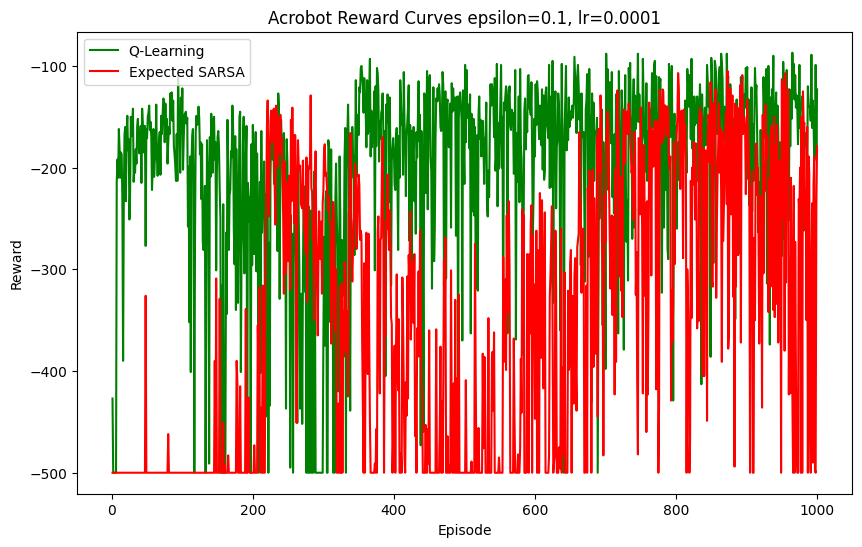

In [43]:
# import time
# start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=0.1, lr=0.0001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
# elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):")

# start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=0.1, lr=0.0001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
# elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves epsilon=0.1, lr=0.0001")
plt.legend()
plt.show()

In [11]:
import time

# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.95
Episode: 1, Total Reward: -500.0, Epsilon: 0.9025
Episode: 2, Total Reward: -500.0, Epsilon: 0.8573749999999999
Episode: 3, Total Reward: -500.0, Epsilon: 0.8145062499999999
Episode: 4, Total Reward: -500.0, Epsilon: 0.7737809374999999
Episode: 5, Total Reward: -500.0, Epsilon: 0.7350918906249998
Episode: 6, Total Reward: -478.0, Epsilon: 0.6983372960937497
Episode: 7, Total Reward: -293.0, Epsilon: 0.6634204312890623
Episode: 8, Total Reward: -190.0, Epsilon: 0.6302494097246091
Episode: 9, Total Reward: -217.0, Epsilon: 0.5987369392383786
Episode: 10, Total Reward: -208.0, Epsilon: 0.5688000922764596
Episode: 11, Total Reward: -161.0, Epsilon: 0.5403600876626365
Episode: 12, Total Reward: -183.0, Epsilon: 0.5133420832795047
Episode: 13, Total Reward: -136.0, Epsilon: 0.48767497911552943
Episode: 14, Total Reward: -203.0, Epsilon: 0.46329123015975293
Episode: 15, Total Reward: -181.0, Epsilon: 0.44012666865176525
Episode: 16, Total Reward

In [12]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.95
Episode: 1, Total Reward: -500.0, Epsilon: 0.9025
Episode: 2, Total Reward: -500.0, Epsilon: 0.8573749999999999
Episode: 3, Total Reward: -500.0, Epsilon: 0.8145062499999999
Episode: 4, Total Reward: -500.0, Epsilon: 0.7737809374999999
Episode: 5, Total Reward: -500.0, Epsilon: 0.7350918906249998
Episode: 6, Total Reward: -500.0, Epsilon: 0.6983372960937497
Episode: 7, Total Reward: -393.0, Epsilon: 0.6634204312890623
Episode: 8, Total Reward: -500.0, Epsilon: 0.6302494097246091
Episode: 9, Total Reward: -500.0, Epsilon: 0.5987369392383786
Episode: 10, Total Reward: -268.0, Epsilon: 0.5688000922764596
Episode: 11, Total Reward: -345.0, Epsilon: 0.5403600876626365
Episode: 12, Total Reward: -298.0, Epsilon: 0.5133420832795047
Episode: 13, Total Reward: -401.0, Epsilon: 0.48767497911552943
Episode: 14, Total Reward: -179.0, Epsilon: 0.46329123015975293
Episode: 15, Total Reward: -226.0, Epsilon: 0.44012666865176525
Episode: 16, Total Reward

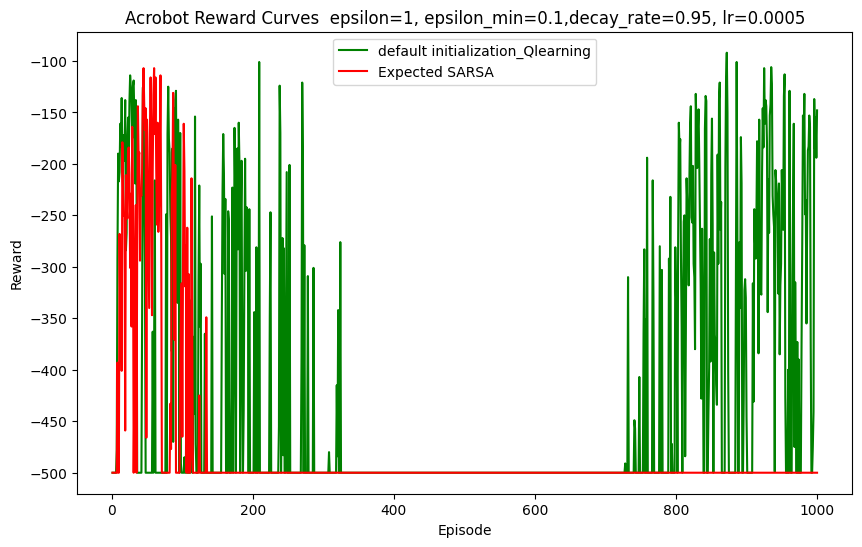

In [13]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Qlearning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.0005")
plt.legend()
plt.show()

In [14]:
# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=1, epsilon_min=0.1,decay_rate=0.99, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.99
Episode: 1, Total Reward: -500.0, Epsilon: 0.9801
Episode: 2, Total Reward: -500.0, Epsilon: 0.9702989999999999
Episode: 3, Total Reward: -500.0, Epsilon: 0.96059601
Episode: 4, Total Reward: -500.0, Epsilon: 0.9509900498999999
Episode: 5, Total Reward: -500.0, Epsilon: 0.9414801494009999
Episode: 6, Total Reward: -500.0, Epsilon: 0.9320653479069899
Episode: 7, Total Reward: -500.0, Epsilon: 0.92274469442792
Episode: 8, Total Reward: -500.0, Epsilon: 0.9135172474836407
Episode: 9, Total Reward: -500.0, Epsilon: 0.9043820750088043
Episode: 10, Total Reward: -500.0, Epsilon: 0.8953382542587163
Episode: 11, Total Reward: -500.0, Epsilon: 0.8863848717161291
Episode: 12, Total Reward: -500.0, Epsilon: 0.8775210229989678
Episode: 13, Total Reward: -500.0, Epsilon: 0.8687458127689781
Episode: 14, Total Reward: -500.0, Epsilon: 0.8600583546412883
Episode: 15, Total Reward: -500.0, Epsilon: 0.8514577710948754
Episode: 16, Total Reward: -500.0, Eps

In [15]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=1, epsilon_min=0.1,decay_rate=0.99, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.99
Episode: 1, Total Reward: -500.0, Epsilon: 0.9801
Episode: 2, Total Reward: -500.0, Epsilon: 0.9702989999999999
Episode: 3, Total Reward: -500.0, Epsilon: 0.96059601
Episode: 4, Total Reward: -500.0, Epsilon: 0.9509900498999999
Episode: 5, Total Reward: -500.0, Epsilon: 0.9414801494009999
Episode: 6, Total Reward: -500.0, Epsilon: 0.9320653479069899
Episode: 7, Total Reward: -500.0, Epsilon: 0.92274469442792
Episode: 8, Total Reward: -500.0, Epsilon: 0.9135172474836407
Episode: 9, Total Reward: -500.0, Epsilon: 0.9043820750088043
Episode: 10, Total Reward: -500.0, Epsilon: 0.8953382542587163
Episode: 11, Total Reward: -500.0, Epsilon: 0.8863848717161291
Episode: 12, Total Reward: -500.0, Epsilon: 0.8775210229989678
Episode: 13, Total Reward: -500.0, Epsilon: 0.8687458127689781
Episode: 14, Total Reward: -500.0, Epsilon: 0.8600583546412883
Episode: 15, Total Reward: -500.0, Epsilon: 0.8514577710948754
Episode: 16, Total Reward: -500.0, Eps

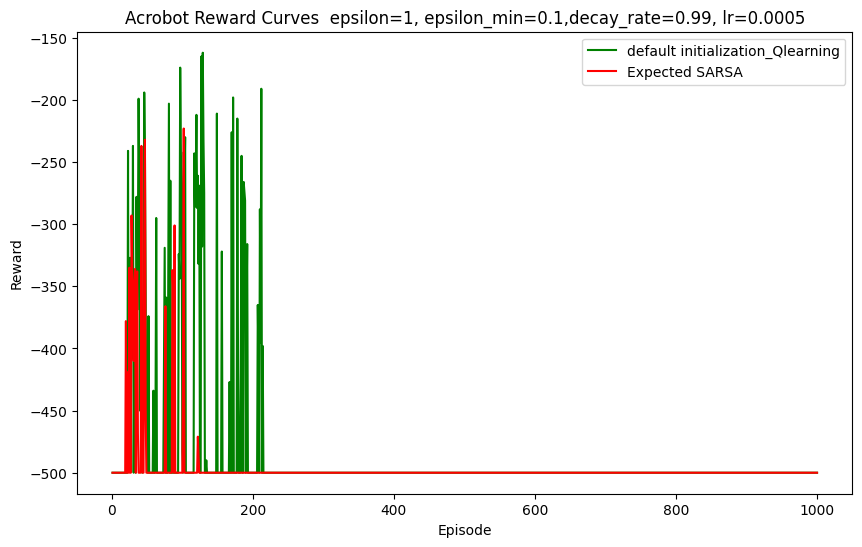

In [16]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Qlearning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=1, epsilon_min=0.1,decay_rate=0.99, lr=0.0005")
plt.legend()
plt.show()

In [17]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=0.2, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.2
Episode: 1, Total Reward: -500.0, Epsilon: 0.2
Episode: 2, Total Reward: -500.0, Epsilon: 0.2
Episode: 3, Total Reward: -464.0, Epsilon: 0.2
Episode: 4, Total Reward: -500.0, Epsilon: 0.2
Episode: 5, Total Reward: -500.0, Epsilon: 0.2
Episode: 6, Total Reward: -500.0, Epsilon: 0.2
Episode: 7, Total Reward: -500.0, Epsilon: 0.2
Episode: 8, Total Reward: -500.0, Epsilon: 0.2
Episode: 9, Total Reward: -500.0, Epsilon: 0.2
Episode: 10, Total Reward: -500.0, Epsilon: 0.2
Episode: 11, Total Reward: -500.0, Epsilon: 0.2
Episode: 12, Total Reward: -500.0, Epsilon: 0.2
Episode: 13, Total Reward: -500.0, Epsilon: 0.2
Episode: 14, Total Reward: -500.0, Epsilon: 0.2
Episode: 15, Total Reward: -500.0, Epsilon: 0.2
Episode: 16, Total Reward: -500.0, Epsilon: 0.2
Episode: 17, Total Reward: -494.0, Epsilon: 0.2
Episode: 18, Total Reward: -264.0, Epsilon: 0.2
Episode: 19, Total Reward: -140.0, Epsilon: 0.2
Episode: 20, Total Reward: -147.0, Epsilon: 0.2
Ep

In [20]:
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                           epsilon=0.2, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

Episode: 0, Total Reward: -500.0, Epsilon: 0.2
Episode: 1, Total Reward: -500.0, Epsilon: 0.2
Episode: 2, Total Reward: -500.0, Epsilon: 0.2
Episode: 3, Total Reward: -500.0, Epsilon: 0.2
Episode: 4, Total Reward: -500.0, Epsilon: 0.2
Episode: 5, Total Reward: -500.0, Epsilon: 0.2
Episode: 6, Total Reward: -500.0, Epsilon: 0.2


KeyboardInterrupt: 

In [ ]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=0.2, lr=0.0005")
plt.legend()
plt.show()

In [ ]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=0.1, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=0.1, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves epsilon=0.1, lr=0.0005")
plt.legend()
plt.show()

Episode: 0, Total Reward: -500.0, Epsilon: 0.2
Episode: 1, Total Reward: -500.0, Epsilon: 0.2
Episode: 2, Total Reward: -500.0, Epsilon: 0.2
Episode: 3, Total Reward: -500.0, Epsilon: 0.2
Episode: 4, Total Reward: -265.0, Epsilon: 0.2
Episode: 5, Total Reward: -351.0, Epsilon: 0.2
Episode: 6, Total Reward: -500.0, Epsilon: 0.2
Episode: 7, Total Reward: -500.0, Epsilon: 0.2
Episode: 8, Total Reward: -335.0, Epsilon: 0.2
Episode: 9, Total Reward: -435.0, Epsilon: 0.2
Episode: 10, Total Reward: -335.0, Epsilon: 0.2
Episode: 11, Total Reward: -370.0, Epsilon: 0.2
Episode: 12, Total Reward: -408.0, Epsilon: 0.2
Episode: 13, Total Reward: -500.0, Epsilon: 0.2
Episode: 14, Total Reward: -500.0, Epsilon: 0.2
Episode: 15, Total Reward: -500.0, Epsilon: 0.2
Episode: 16, Total Reward: -500.0, Epsilon: 0.2
Episode: 17, Total Reward: -500.0, Epsilon: 0.2
Episode: 18, Total Reward: -500.0, Epsilon: 0.2
Episode: 19, Total Reward: -500.0, Epsilon: 0.2
Episode: 20, Total Reward: -500.0, Epsilon: 0.2
Ep

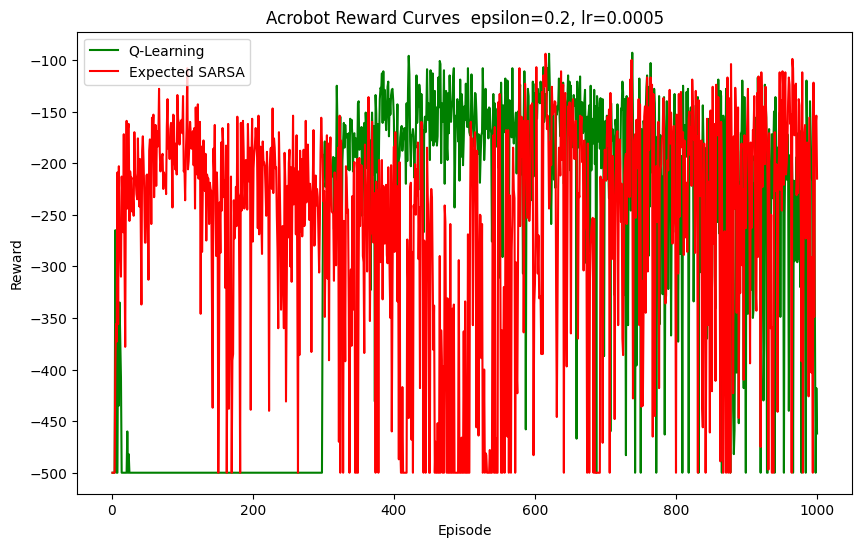

In [21]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=0.2, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=0.2, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=0.2, lr=0.0005")
plt.legend()
plt.show()

W replay

Episode: 0, Total Reward: -500.0, Epsilon: 0.2
Episode: 1, Total Reward: -500.0, Epsilon: 0.2
Episode: 2, Total Reward: -360.0, Epsilon: 0.2
Episode: 3, Total Reward: -290.0, Epsilon: 0.2
Episode: 4, Total Reward: -500.0, Epsilon: 0.2
Episode: 5, Total Reward: -500.0, Epsilon: 0.2
Episode: 6, Total Reward: -500.0, Epsilon: 0.2
Episode: 7, Total Reward: -500.0, Epsilon: 0.2
Episode: 8, Total Reward: -456.0, Epsilon: 0.2
Episode: 9, Total Reward: -500.0, Epsilon: 0.2
Episode: 10, Total Reward: -385.0, Epsilon: 0.2
Episode: 11, Total Reward: -236.0, Epsilon: 0.2
Episode: 12, Total Reward: -273.0, Epsilon: 0.2
Episode: 13, Total Reward: -500.0, Epsilon: 0.2
Episode: 14, Total Reward: -488.0, Epsilon: 0.2
Episode: 15, Total Reward: -354.0, Epsilon: 0.2
Episode: 16, Total Reward: -252.0, Epsilon: 0.2
Episode: 17, Total Reward: -181.0, Epsilon: 0.2
Episode: 18, Total Reward: -370.0, Epsilon: 0.2
Episode: 19, Total Reward: -243.0, Epsilon: 0.2
Episode: 20, Total Reward: -172.0, Epsilon: 0.2
Ep

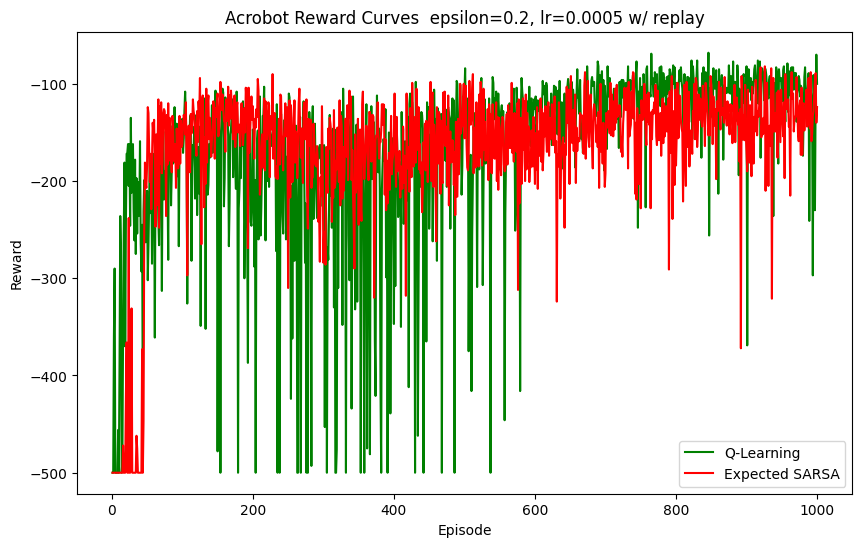

In [22]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=True,
                           epsilon=0.2, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=True,
                            epsilon=0.2, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=0.2, lr=0.0005 w/ replay")
plt.legend()
plt.show()

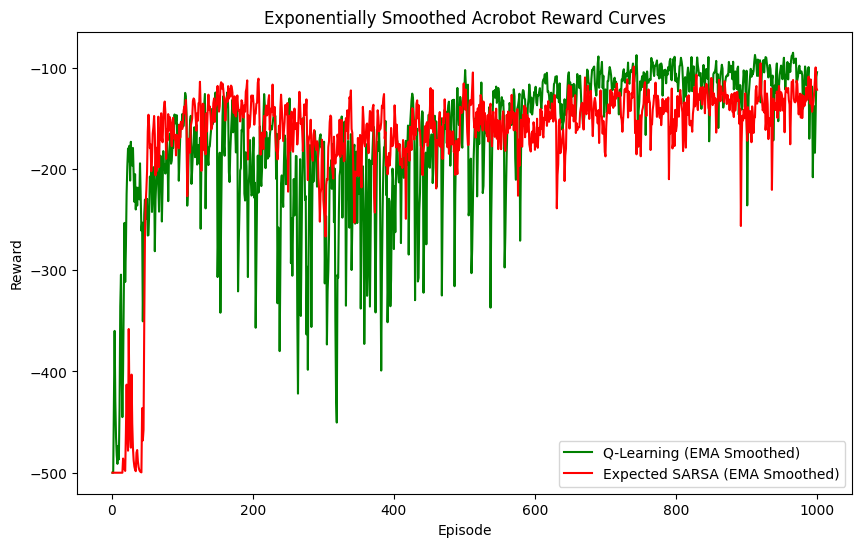

In [24]:
def exponential_moving_average(data, alpha=0.1):
    smoothed = []
    smoothed.append(data[0])  # First value remains the same
    for i in range(1, len(data)):
        smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[-1])
    return smoothed

alpha = 0.5  # Adjust smoothness factor

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

Episode: 0, Total Reward: -500.0, Epsilon: 0.3
Episode: 1, Total Reward: -500.0, Epsilon: 0.3
Episode: 2, Total Reward: -286.0, Epsilon: 0.3
Episode: 3, Total Reward: -237.0, Epsilon: 0.3
Episode: 4, Total Reward: -160.0, Epsilon: 0.3
Episode: 5, Total Reward: -135.0, Epsilon: 0.3
Episode: 6, Total Reward: -93.0, Epsilon: 0.3
Episode: 7, Total Reward: -152.0, Epsilon: 0.3
Episode: 8, Total Reward: -399.0, Epsilon: 0.3
Episode: 9, Total Reward: -309.0, Epsilon: 0.3
Episode: 10, Total Reward: -112.0, Epsilon: 0.3
Episode: 11, Total Reward: -113.0, Epsilon: 0.3
Episode: 12, Total Reward: -116.0, Epsilon: 0.3
Episode: 13, Total Reward: -152.0, Epsilon: 0.3
Episode: 14, Total Reward: -91.0, Epsilon: 0.3
Episode: 15, Total Reward: -110.0, Epsilon: 0.3
Episode: 16, Total Reward: -129.0, Epsilon: 0.3
Episode: 17, Total Reward: -117.0, Epsilon: 0.3
Episode: 18, Total Reward: -150.0, Epsilon: 0.3
Episode: 19, Total Reward: -122.0, Epsilon: 0.3
Episode: 20, Total Reward: -105.0, Epsilon: 0.3
Epis

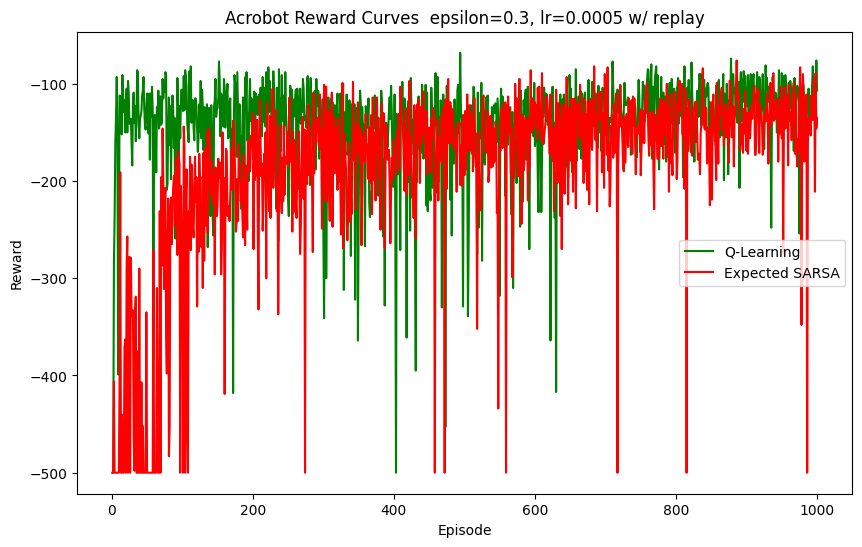

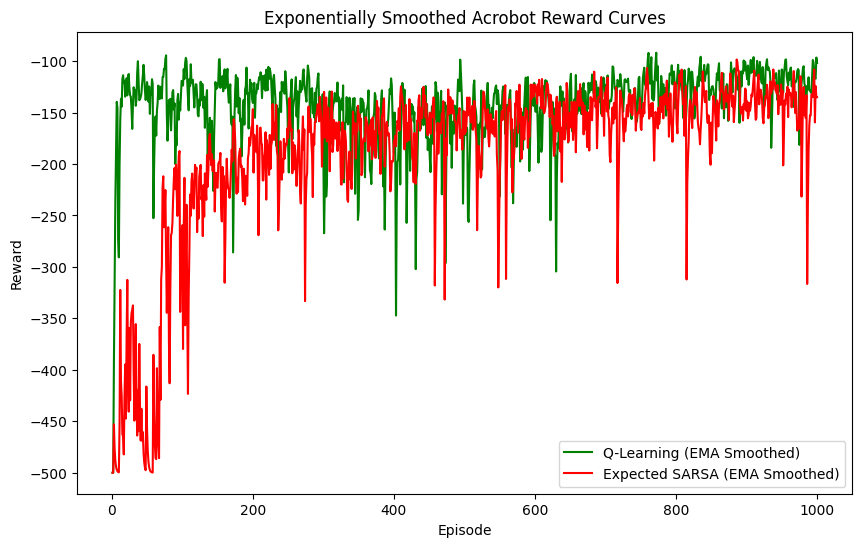

In [25]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=True,
                           epsilon=0.3, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=True,
                            epsilon=0.3, lr=0.00005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=0.3, lr=0.00005 w/ replay")
plt.legend()
plt.show()

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

Episode: 0, Total Reward: -500.0, Epsilon: 0.3
Episode: 1, Total Reward: -500.0, Epsilon: 0.3
Episode: 2, Total Reward: -166.0, Epsilon: 0.3
Episode: 3, Total Reward: -144.0, Epsilon: 0.3
Episode: 4, Total Reward: -111.0, Epsilon: 0.3
Episode: 5, Total Reward: -142.0, Epsilon: 0.3
Episode: 6, Total Reward: -125.0, Epsilon: 0.3
Episode: 7, Total Reward: -122.0, Epsilon: 0.3
Episode: 8, Total Reward: -124.0, Epsilon: 0.3
Episode: 9, Total Reward: -150.0, Epsilon: 0.3
Episode: 10, Total Reward: -153.0, Epsilon: 0.3
Episode: 11, Total Reward: -149.0, Epsilon: 0.3
Episode: 12, Total Reward: -123.0, Epsilon: 0.3
Episode: 13, Total Reward: -209.0, Epsilon: 0.3
Episode: 14, Total Reward: -205.0, Epsilon: 0.3
Episode: 15, Total Reward: -105.0, Epsilon: 0.3
Episode: 16, Total Reward: -126.0, Epsilon: 0.3
Episode: 17, Total Reward: -143.0, Epsilon: 0.3
Episode: 18, Total Reward: -130.0, Epsilon: 0.3
Episode: 19, Total Reward: -221.0, Epsilon: 0.3
Episode: 20, Total Reward: -254.0, Epsilon: 0.3
Ep

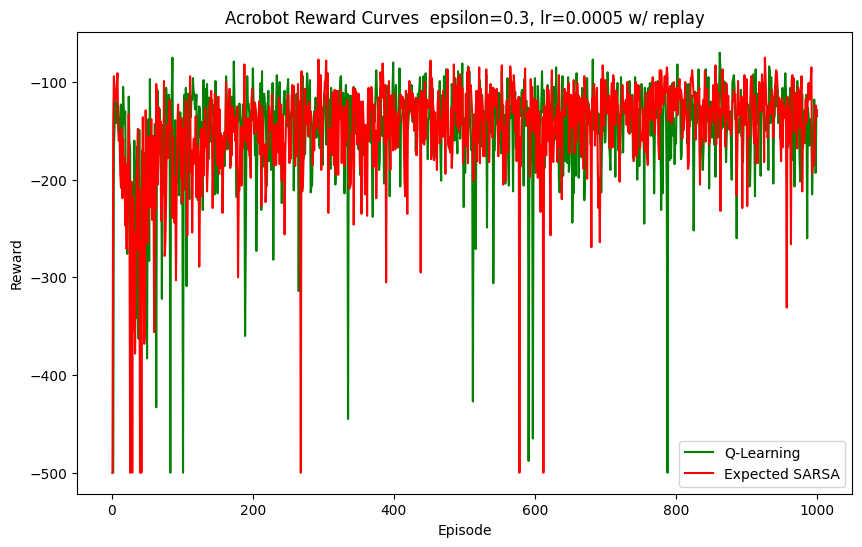

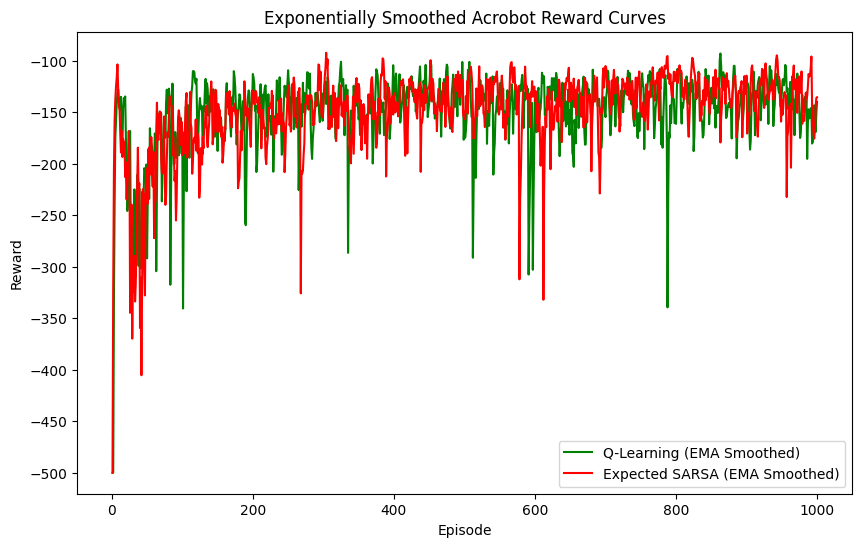

In [26]:
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=True,
                           epsilon=0.3, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=True,
                            epsilon=0.3, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves  epsilon=0.3, lr=0.0005 w/ replay")
plt.legend()
plt.show()

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

In [31]:
start_time = time.time()
rewards_q = run_experiment("ALE/Assault-ram-v5", "q_learning", use_replay=True,
                           epsilon=0.3, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

start_time = time.time()
rewards_es = run_experiment("ALE/Assault-ram-v5", "expected_sarsa", use_replay=True,
                            epsilon=0.3, lr=0.0005, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("ALE/Assault-ram-v5 Reward Curves  epsilon=0.3, lr=0.0005 w/ replay")
plt.legend()
plt.show()

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("ALE/Assult-ram-v5 Exponentially Smoothed Reward Curves")
plt.legend()
plt.show()

Episode: 0, Total Reward: 315.0, Epsilon: 0.3
Episode: 1, Total Reward: 189.0, Epsilon: 0.3
Episode: 2, Total Reward: 168.0, Epsilon: 0.3
Episode: 3, Total Reward: 210.0, Epsilon: 0.3
Episode: 4, Total Reward: 210.0, Epsilon: 0.3
Episode: 5, Total Reward: 147.0, Epsilon: 0.3
Episode: 6, Total Reward: 378.0, Epsilon: 0.3
Episode: 7, Total Reward: 105.0, Epsilon: 0.3
Episode: 8, Total Reward: 189.0, Epsilon: 0.3
Episode: 9, Total Reward: 231.0, Epsilon: 0.3
Episode: 10, Total Reward: 336.0, Epsilon: 0.3
Episode: 11, Total Reward: 273.0, Epsilon: 0.3
Episode: 12, Total Reward: 168.0, Epsilon: 0.3
Episode: 13, Total Reward: 336.0, Epsilon: 0.3
Episode: 14, Total Reward: 378.0, Epsilon: 0.3
Episode: 15, Total Reward: 294.0, Epsilon: 0.3
Episode: 16, Total Reward: 252.0, Epsilon: 0.3
Episode: 17, Total Reward: 210.0, Epsilon: 0.3
Episode: 18, Total Reward: 231.0, Epsilon: 0.3
Episode: 19, Total Reward: 378.0, Epsilon: 0.3
Episode: 20, Total Reward: 189.0, Epsilon: 0.3
Episode: 21, Total Rewa

KeyboardInterrupt: 

In [27]:
import time

# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=False,
                           epsilon=0.1, lr=0.0001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

In [28]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=False,
                            epsilon=0.1, lr=0.0001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

In [29]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves (Max 500 Steps per Episode)")
plt.legend()
plt.show()

In [31]:
def exponential_moving_average(data, alpha=0.1):
    smoothed = []
    smoothed.append(data[0])  # First value remains the same
    for i in range(1, len(data)):
        smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[-1])
    return smoothed

alpha = 0.05  # Adjust smoothness factor

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

2# Check how long it takes with replay buffer

In [16]:
import time

# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=True,
                           epsilon=0.1, lr=0.001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

In [17]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=True,
                            epsilon=0.1, lr=0.001, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

In [18]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves (Max 500 Steps per Episode)")
plt.legend()
plt.show()

In [19]:
def exponential_moving_average(data, alpha=0.1):
    smoothed = []
    smoothed.append(data[0])  # First value remains the same
    for i in range(1, len(data)):
        smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[-1])
    return smoothed

alpha = 0.05  # Adjust smoothness factor

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

do decaying epsilon

In [32]:
import time

# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("Acrobot-v1", "q_learning", use_replay=True,
                           epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.1, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

In [33]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment("Acrobot-v1", "expected_sarsa", use_replay=True,
                            epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.1, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

In [34]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="Q-Learning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves (Max 500 Steps per Episode)")
plt.legend()
plt.show()

In [35]:
def exponential_moving_average(data, alpha=0.1):
    smoothed = []
    smoothed.append(data[0])  # First value remains the same
    for i in range(1, len(data)):
        smoothed.append(alpha * data[i] + (1 - alpha) * smoothed[-1])
    return smoothed

alpha = 0.05  # Adjust smoothness factor

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

Check for assult

In [14]:

print([env for env in gym.envs.registry.keys() if "Assault" in env])


In [15]:
import time

# Example for Q-Learning on Acrobot
start_time = time.time()
rewards_q = run_experiment("ALE/Assault-ram-v5", "q_learning", use_replay=False,
                           epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.1, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_q = time.time() - start_time
print("Q-Learning run time for Acrobot (max 500 steps/episode):", elapsed_time_q, "seconds")

In [ ]:
# Example for Expected SARSA on Acrobot
start_time = time.time()
rewards_es = run_experiment('ALE/Assault-ram-v5', "expected_sarsa", use_replay=False,
                            epsilon=1, epsilon_min=0.1,decay_rate=0.95, lr=0.1, seed=0, episodes=1000, gamma=0.99, batch_size=32)
elapsed_time_es = time.time() - start_time
print("Expected SARSA run time for Acrobot (max 500 steps/episode):", elapsed_time_es, "seconds")

In [36]:
episodes_range = range(1, 1001)
plt.figure(figsize=(10, 6))
plt.plot(episodes_range, rewards_q, label="default initialization_Qlearning", color='green')
plt.plot(episodes_range, rewards_es, label="Expected SARSA", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Acrobot Reward Curves (Max 500 Steps per Episode)")
plt.legend()
plt.show()

alpha = 0.05  # Adjust smoothness factor

smoothed_rewards_q = exponential_moving_average(rewards_q, alpha)
smoothed_rewards_es = exponential_moving_average(rewards_es, alpha)

plt.figure(figsize=(10, 6))
plt.plot(episodes_range, smoothed_rewards_q, label="Q-Learning (EMA Smoothed)", color='green')
plt.plot(episodes_range, smoothed_rewards_es, label="Expected SARSA (EMA Smoothed)", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Exponentially Smoothed Acrobot Reward Curves")
plt.legend()
plt.show()

Run all experiments

In [51]:

# Create a directory to save plots if it doesn't exist
os.makedirs("plots", exist_ok=True)

# List of environments
env_list = ['Acrobot-v1', 'ALE/Assault-ram-v5']
#  epsilon values 
epsilon_list = [0.05, 0.1, 0.15]
# Step-size parameters 
lr_list = [0.01, 0.001, 0.0001]
# Algorithms to compare
algorithms = ['q_learning', 'expected_sarsa']
# Whether to use replay buffer or not
replay_options = [False, True]

num_seeds = 10      # 10 learning trials
episodes = 1000     # 1000 episodes per run
gamma = 0.99        # Discount factor

# Loop over each environment
for env_name in env_list:
    # For each replay configuration
    for use_replay in replay_options:
        # For each combination of epsilon and step-size (lr)
        for epsilon in epsilon_list:
            for lr in lr_list:
                # For each algorithm: Q-learning (green) and Expected SARSA (red)
                for algo in algorithms:
                    title = (f"{env_name} - {algo.upper()} - " +
                             f"{'Replay' if use_replay else 'No Replay'} - " +
                             f"ϵ: {epsilon}, LR: {lr}")
                    print("Running:", title)
                    mean_rewards, std_rewards = run_multiple_trials(env_name, algo,
                                                                    use_replay, epsilon,
                                                                    lr,
                                                                    episodes)
                    # Save the plot
                    fname = f"plots/{env_name}_{algo}_{'replay' if use_replay else 'no_replay'}_eps{epsilon}_lr{lr}.png"
                    plot_results(mean_rewards, std_rewards, episodes, title, fname)
                    print(f"Saved plot to {fname}")